# RJ's VotingSim Quickstart

## Introduction

Back in 2016, when Donald Trump won election to be the President, there was a lot of fussing about illegal voting and electorla voting and young people voting and voting in general. While I have some thoughts about illegal voting (hasn't proved to be a significant problem) and the electoral college ([not great Bob](https://images.app.goo.gl/h93DqB73thZRu6Vh8)) and young people voting (definitely a good thing), something that reall caught my attention was this thing called [*Ranked Choice Voting*](https://en.wikipedia.org/wiki/Ranked_voting).

I probably had heard of it before, but had never considered it fully before the 2016 election, instead believing in the sancity and perfectness of the American election form. But after the election I was thinking: maybe another voting system is better? 

Thus I had the idea for this project, which very naturally I didn't fully pick up until 2023. I only have one goal for this project, and that is to evaluate a number of vote tallying strategies on various population distributions. But other than that, I'm just going to jump right in. Maybe if this ever gets to some stage of completeness I'll come back and write a real description. :)

## Brief Overview of Some Voting Styles
It seems necesary to briefly describe the voting strategies I'm interested in. Just to cover all my bases, all voting situations are made up and all descriptions are *at best* poorly researched.

### Classic
Given a list of $n$ candidates, a voter can select $1$ candidate to vote for. This is seen in the American election style. Whichever candidate receives the most votes is elected (leaving out the possibility of three candidate situations for now, where a plurality would be sufficient to win). I think this situation needs no further explanation.

### Ranked Choice
Given a list of $n$ candidates, a voter can **rank** some number $m$ candidates, where $m \le n$, in the order they would prefer. When votes are tallied, all ballots are counted for the candidate ranked at the top of that specific ballot. If some candidate receives the majority of votes, then great, they win. If not, then the lowest scoring candidate is eliminated. Any ballots with the eliminated candidate specified have that entry crossed off, and tallying happens again with $n-1$ candidates.

**An example:** Let us assume there are 3 candidates: Arty, Bella, and Christy. Let us consider 5 voter, who will be numbered for simplicity. Let's say in this format each voter can specify 2 candidates in their preferred order. Voting might look like this:

1. Arty, Chirsty
2. Bella, Arty
3. Christy, Arty
4. Arty, Bella
5. Bella, Christy

After the first round of voting we have the following tally:
| Candidate | Votes |
|-----------|-------|
| Arty      | 2     |
| Bella     | 2     |
| Christy   | 1  

Ah shoot! No one wins. Well now we eliminate the lowest scoring candidate (Bye Christy, it was you refusal to say puppies are cute that doomed you). So now we need to refresh our ballots:
1. Arty, ~~Chirsty~~
2. Bella, Arty
3. ~~Christy~~, Arty
4. Arty, Bella
5. Bella, ~~Christy~~

So now our tally looks like:
| Candidate | Votes |
|-----------|-------|
| Arty      | 3     |
| Bella     | 2     |

Woohoo we have a winner. Some things about ranked choice:

- It allows voters to vote for an unpopular candidate whom they prefer, without throwing away votes as happens in a 2 candidate system like the US.   |  |

## Lets write some code
Ok enough jibber jabber, lets start defining our simulator. Wait first some imports and such.

Also if it wasn't obvious, I'm using this project as an opportunity to teach myself some libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

Well, actually, maybe lets think through some requirements for now.

I want to start with a purely 2-D system. Each voter and candidate will fall somewhere on the real number line which represents their position on some issue. Maybe it's Democrat vs Republican, maybe its coffe vs tea, or maybe it's people who don't use turn signals should be violently executed vs ... not that.

The idea is eventually compare these voting algorithms on a variety of probability distributions from which we will sample our population of voters. It'll be easiest if we have our center at 0 and let's restrict our candidates to the range $[-4, 4]$, choosen because on a normal curve with mean $\mu = 0$ and standard deviation $\sigma = 1$, the probability of selecting a value outside that range is effectively 0.

For now let's just hardcode some stuff, we can come back and be general later.

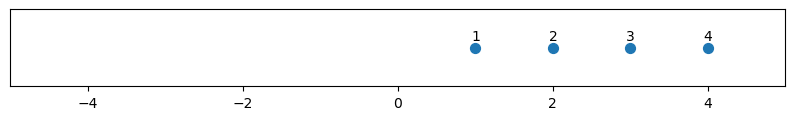

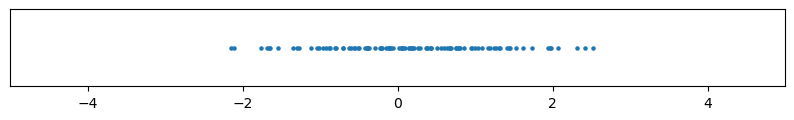

In [36]:
# Quickly, a number line plotting function might be helpful, so lets just do that quickly
def number_line_plot(x, text_labels=None, text_size=10, dot_size=50, x_lim=[-5,5]):
    fig, ax = plt.subplots()
    plt.scatter(np.array(x), np.zeros(x.shape), s=dot_size)
    # fig = plt.gcf()
    # ax = plt.gca()
    fig.set_figheight(1)
    fig.set_figwidth(10)
    ax.set_xlim(x_lim)
    ax.set_ylim([-1,1])
    ax.get_yaxis().set_visible(False)

    if text_labels is not None and x.size==len(text_labels):
        for i, label in enumerate(text_labels):
            ax.annotate(label, (x[i]-(len(label) * 0.05), 0.2), fontsize=text_size)
    return ax

ax = number_line_plot(np.array([1,2,3,4]), text_labels=['1', '2', '3', '4'])
plt.show()
ax = number_line_plot(np.random.normal(size=(100,)), dot_size=5)

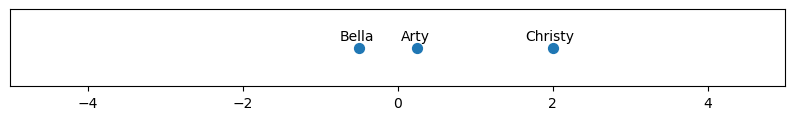

In [33]:
candidates = {'Arty': 0.25,
              'Bella': -0.5,
              'Christy': 2}

ax = number_line_plot(np.array(list(candidates.values())), text_labels=candidates.keys())

Ok now let's think about our voters. Like our candidates, they're represented by a location on the number line showing where they fall on ourr non-offensive political issue. However it is worth explicitly laying out how the position of a voter relates to their voting behavior. A voter at position $x$ wants to vote for the candidate that minimizes $\mid x - c \mid$, where $c$ is the position of the candidate.

In a classic election (America style) that means our citizen votes for the closest candidate to their position. For ranked choice voting, the voters top choice would be the closest to their position, the second choice would be the second closest, etc...